<a href="https://colab.research.google.com/github/hufsaim/T10306201/blob/master/notebook_2025/Lab10_LeNet_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder, DatasetFolder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


## Download MNIST and Prepare Data Loader

In [3]:
path0 = '.'

transform = v2.Compose(
    [
        v2.ToTensor(),
        v2.Grayscale(),
        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
        v2.RandomCrop(size=(28, 28)),
        ]
    )

transform_val = v2.Compose(
    [
        v2.ToTensor(),
        v2.Grayscale(),
        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
        v2.CenterCrop(size=(28, 28)),
        ]
    )

mnist_train = torchvision.datasets.MNIST(path0, train=True, transform=transform, target_transform=None, download=True)
mnist_valid = torchvision.datasets.MNIST(path0, train=False, transform=transform_val, target_transform=None, download=True)
def get_mnist_labels(labels):
    text_labels = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

# defining data_iter, linreg. model, loss, sgd
batch_size = 100
num_workers = 0
train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
valid_iter = DataLoader(mnist_valid, batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
                 ToTensor()
                 Grayscale(num_output_channels=1)
                 ToDtype(scale=True)
                 RandomCrop(size=(28, 28), pad_if_needed=False, fill=0, padding_mode=constant)
           )

In [5]:
mnist_valid

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
                 ToTensor()
                 Grayscale(num_output_channels=1)
                 ToDtype(scale=True)
                 CenterCrop(size=(28, 28))
           )

torch.Size([100])
torch.Size([100, 1, 28, 28])


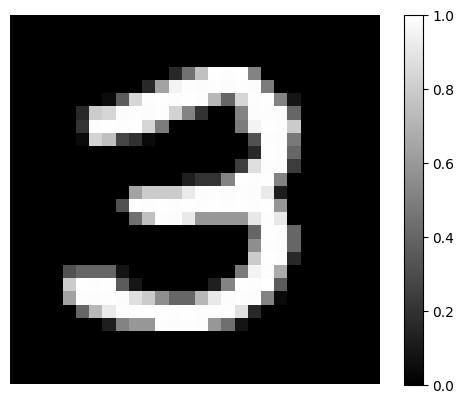

['3']


In [6]:
for images, labels in train_iter:
  print(labels.shape)
  print(images.shape)
  I = images[0].numpy()
  plt.figure(dpi=100)
  plt.imshow(I[0],cmap='gray')
  plt.axis('off')
  plt.colorbar()
  plt.show()
  print(get_mnist_labels([labels[0]]))
  break

## illustration of torchivision transforms
torchvision에서 제공하는 다양한 transform들을 적절히 transform (data augmentation) 에 추가하여 model의 generality를 높이자.
https://pytorch.org/vision/main/transforms.html


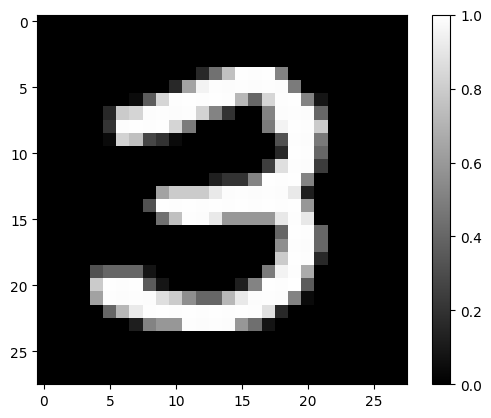

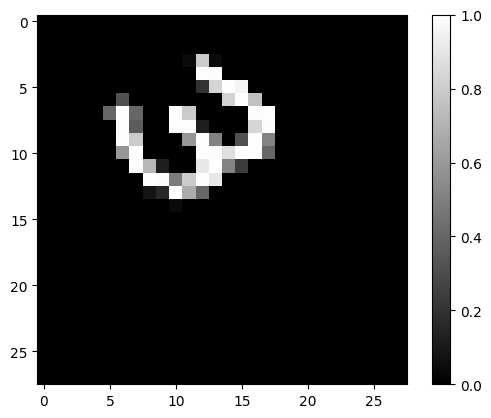

In [7]:
t_imges = v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))(images)
plt.imshow(images[0,0],cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(t_imges[0,0],cmap='gray')
plt.colorbar()
plt.show()

In [8]:
transform = v2.Compose(
    [
        v2.ToTensor(),
        v2.Grayscale(),
        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input

        v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),        # <-- add your transforms
        # ~~
        # v1.~~
        # ~~
        # v2.~~

        v2.RandomCrop(size=(28, 28)),
        ]
    )

## Network
- 강의노트의 LeNet architecture를 기반으로 CNN model을 정의하기

In [9]:
net = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=16*5*5, out_features=120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)
net = net.to(device)
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

- (1, 1, 28, 28) 크기로 정의한 input이 각각의 layer에서 어떤 크기로 변환되는 지를 확인하고 이해하자.

In [10]:
X = torch.randn(size=(1,1,28,28), dtype = torch.float32)
X = X.to(device)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


## Hyperparameters
- learning rate, number of epochs, loss function, algorithm 을 적절하게 정의하기

In [11]:
# setting hyper-parameters
learning_rate = .01
num_epochs = 2

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.Adam(net.parameters(),lr=learning_rate) # sgd

## Train a Model
- training set/validation set를 활용하여 model을 학습시키기

In [12]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device) # GPU
    alg.zero_grad()
    y_hat=net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    l.backward()
    alg.step()

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,(100*correct.cpu())/len(mnist_train))

  correct = 0
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat = net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()

  accs_valid = np.append(accs_valid,(100*correct.cpu())/len(mnist_valid))

  if epoch%8 == 3:
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.show()

  print('epoch #:',epoch,'train loss: ',loss_train[-1],'train accuracy: ',accs_train[-1],'valid accuracy: ',accs_valid[-1])

epoch #: 0 train loss:  0.21231681108474731 train accuracy:  93.26166534423828 valid accuracy:  98.05000305175781
epoch #: 1 train loss:  0.07590027153491974 train accuracy:  97.82666778564453 valid accuracy:  98.16999816894531


In [13]:
#torch.save(net.state_dict(),f'my_best_model.pth')

## Results (Validation Set)
- validation set에 대한 결과를 요약해보자.

In [14]:
i = 0
y_all=[]
y_hat_all=[]
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = net(X)
  y_hat = y_hat.argmax(dim=1)
  y_all.append(y)
  y_hat_all.append(y_hat)
y_all = torch.cat(y_all,dim=0)
y_hat_all = torch.cat(y_hat_all,dim=0)

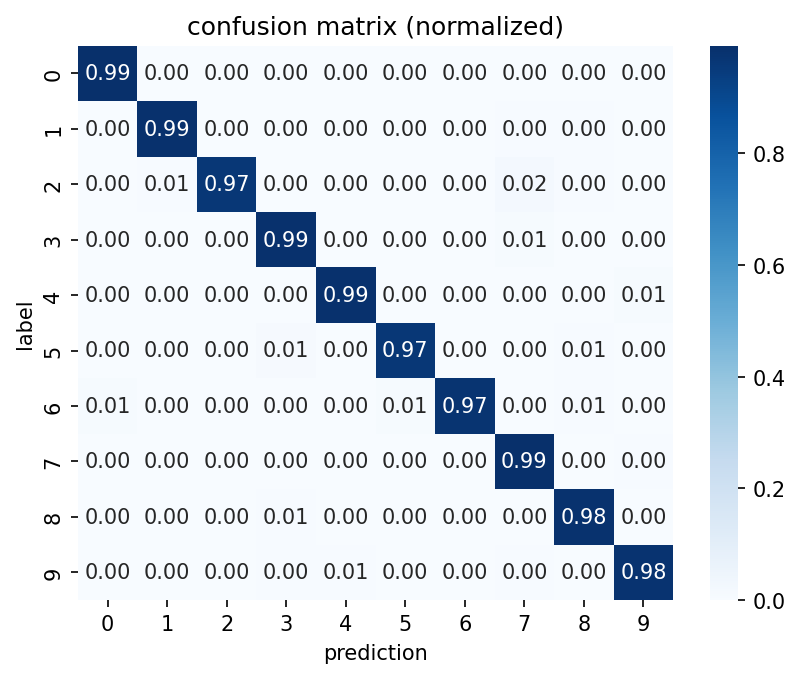

In [15]:
cf = confusion_matrix(y_all.numpy(),y_hat_all.cpu().numpy())
plt.figure(dpi=150)
cf = cf/np.sum(cf,axis=1)
sns.heatmap(cf,annot=True,cmap='Blues',fmt=".2f")
plt.title('confusion matrix (normalized)')
plt.ylabel('label')
plt.xlabel('prediction')
plt.show()

## Results (External Test Set)
- training set / validation set 과는 다른 방법으로 얻어진 데이터에 대해서 모델의 성능을 평가하고, 이에 대한 성능을 개선시킬 수 있는 방법을 고민하자.

In [16]:
#!unzip hufs_mnist_2025 -d test

In [19]:
transform_test = v2.Compose(
    [
        v2.Grayscale(),
        v2.Resize((32,32)),
        v2.CenterCrop(28),
        v2.ToTensor()
    ])

In [20]:
path_test = 'test/hard' # replace with your path
data_test = ImageFolder(root=path_test,transform=transform_test)
#net.load_state_dict(torch.load(f'my_best_model.pth'))

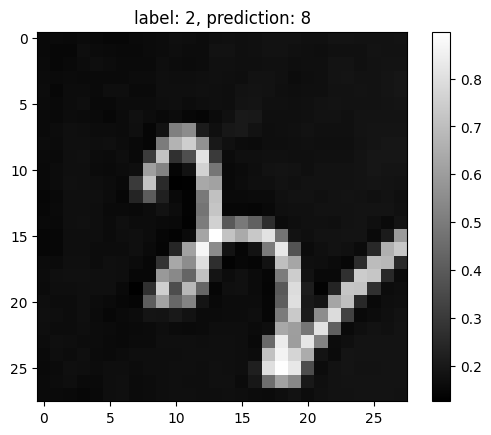

In [21]:
n=32
X = 1-data_test[n][0].unsqueeze(0)
y = data_test[n][1]
y_hat = net(X.to(device))
y_hat = y_hat.argmax(dim=1)
plt.imshow(X[0,0],cmap='gray')
plt.title(f'label: {y}, prediction: {y_hat.cpu().numpy()[0]}')
plt.colorbar()
plt.show()

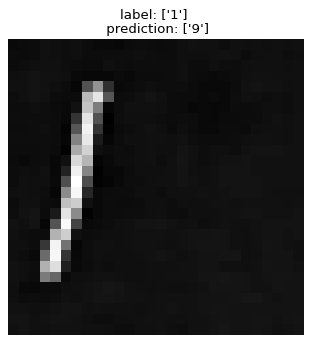

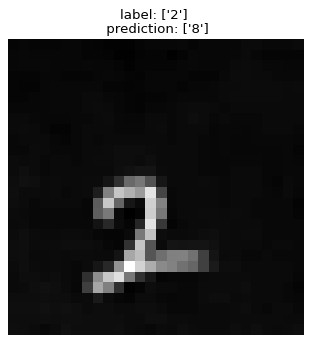

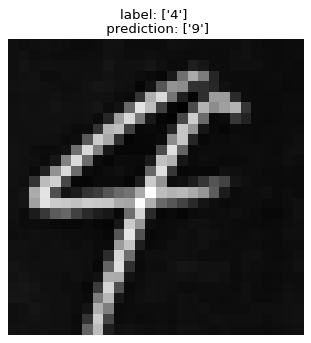

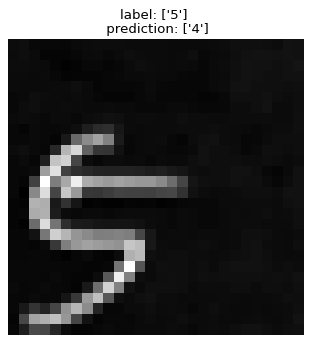

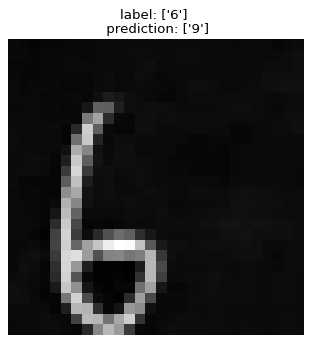

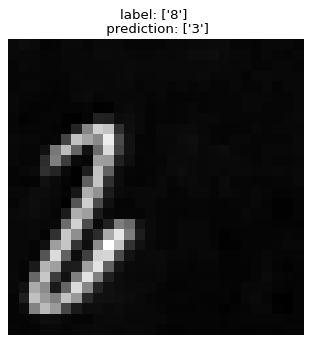

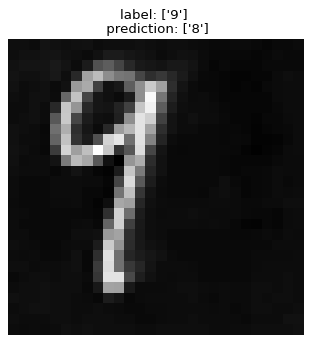

accuracy: 18.571428571428573
number of incorrect predictions: 114
number of correct predictions: 26


In [22]:
#len(data_test)
results = np.zeros((2,len(data_test)))
num_incorrect = 0
flag_plot = 1
for n in range(len(data_test)):
  X = 1 - data_test[n][0].unsqueeze(0)
  y = data_test[n][1]
  y_hat = net(X.to(device))
  y_hat = y_hat.argmax(dim=1)

  results[0,n] = y
  results[1,n] = y_hat
  if y_hat != y:
    num_incorrect+=1
    if num_incorrect%16==0:
      if flag_plot == 1:
        plt.figure(dpi=80)
        plt.imshow(X[0].cpu().squeeze(),cmap='gray')
        plt.title('label: %s \n prediction: %s'%(get_mnist_labels([y]),get_mnist_labels([y_hat])))
        plt.axis('off')
        plt.show()

acc = 100*(len(data_test)-num_incorrect)/len(data_test)
print(f'accuracy: {acc}')
print(f'number of incorrect predictions: {num_incorrect}')
print(f'number of correct predictions: {len(data_test)-num_incorrect}')

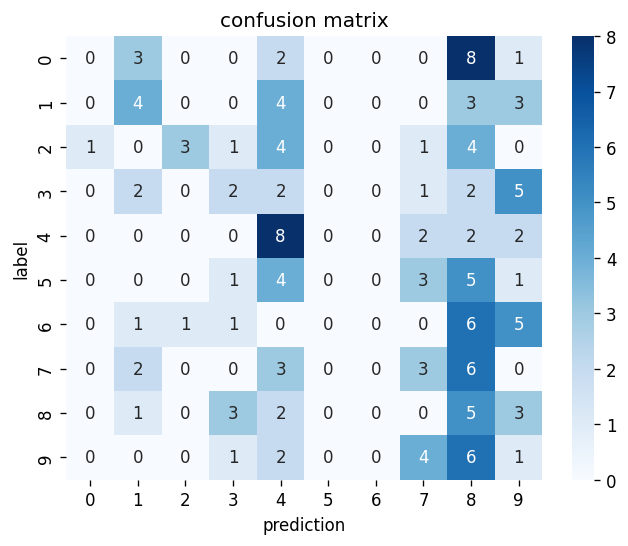

In [23]:
cf = confusion_matrix(results[0,:],results[1,:])
plt.figure(dpi=120)
sns.heatmap(cf,annot=True,cmap='Blues')
plt.title('confusion matrix')
plt.ylabel('label')
plt.xlabel('prediction')
plt.show()

## Homework
- transform, model, hyperparameter 등을 적절하게 수정하여 external test set에 대한 accuracy를 높여보자.